Parallel tree boosting. XGBOOST

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import FeatureHasher

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import f1_score
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!kaggle competitions download -c nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

'=1.6'			 Miniconda3-4.5.4-Linux-x86_64.sh
 catboost_info		 resultadosCNN.csv
 CatBoost.ipynb		 resultados.csv
 colsample_bylevel.png	 resultadosRF.csv
 dfdatos		 resultadosRoberta.csv
 dftrain		 rf_5trees.png
 do2vec.model		 rf_individualtree.png
 glove.6B.100d.txt	 sample_submission.csv
 glove.6B.200d.txt	 test.csv
 glove.6B.300d.txt	 train.csv
 glove.6B.50d.txt	 Untitled0.ipynb
 glove.6B.zip		 wandb
 glove.6B.zip.1		 XGBoost.ipynb
 kaggle.json


In [ ]:
train=pd.read_csv("train.csv",encoding='latin-1')
datos =pd.read_csv("test.csv",encoding='latin-1')
datos.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
#Separo el target de los tweets
target = train.iloc[:,-1]

In [ ]:
#Aplico operaciones sobre train que luego replicare en el set de datos, para obtener los indices que yo considero relevantes
#y deshacerme de los que no lo son
#Empiezo por las arroba
train['cantidad@']=train['text'].str.count('@')
datos['cantidad@']=datos['text'].str.count('@')
train.head()

,id,keyword,location,text,target,cantidad@
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0


In [ ]:
#Aplico una funcion de hash sobre la location
#Primero fijo los NaN como la cadena "ninguna"
#Luego proceso eliminando mayusculas haciendo lemmatize
import spacy
def reemplazarTexto(x):
  x=x.casefold()
  return x

def procesarLocation(df):
  df['location']=df['location'].fillna(value='none')
  return df['location'].apply(lambda x:reemplazarTexto(x))
train['location']=procesarLocation(train)
datos['location']=procesarLocation(datos)

nlp = spacy.load("en_core_web_sm")
def proc(texts):
  l=''
  if (texts=='none'):
    return 'none'
  tokens=nltk.word_tokenize(texts)
  for doc in nlp.pipe(tokens, disable=["tagger"]):
      for ent in doc.ents:
        if ([(ent.text,ent.label_)]!=[]) & (ent.label_=='GPE'):
            l+= ent.text+','
  if l=='':
    return 'no valida'
  return l
train['locationLimpia']=train['location'].apply(lambda x:proc(x))
datos['locationLimpia']=datos['location'].apply(lambda x:proc(x))

In [ ]:
def crearFeatureHasher(serie,ndf):
  fh = FeatureHasher(n_features=6, input_type='string')
  sp = fh.fit_transform(serie)
  df = pd.DataFrame(sp.toarray(), columns=['fh1', 'fh2', 'fh3', 'fh4', 'fh5', 'fh6'])
  ndf=pd.concat([ndf, df], axis=1)
  return ndf
train=crearFeatureHasher(train['locationLimpia'],train)
datos=crearFeatureHasher(datos['locationLimpia'],datos)
train.head()

,id,keyword,location,text,target,cantidad@,locationLimpia,fh1,fh2,fh3,fh4,fh5,fh6
0,1,NaN,none,Our Deeds are the Reason of this #earthquake M...,1,0,none,-2.0,2.0,0.0,0.0,0.0,0.0
1,4,NaN,none,Forest fire near La Ronge Sask. Canada,1,0,none,-2.0,2.0,0.0,0.0,0.0,0.0
2,5,NaN,none,All residents asked to 'shelter in place' are ...,1,0,none,-2.0,2.0,0.0,0.0,0.0,0.0
3,6,NaN,none,"13,000 people receive #wildfires evacuation or...",1,0,none,-2.0,2.0,0.0,0.0,0.0,0.0
4,7,NaN,none,Just got sent this photo from Ruby #Alaska as ...,1,0,none,-2.0,2.0,0.0,0.0,0.0,0.0


In [ ]:
#Analizo longitud de los tweets
#Convertir lo categorico en binario usando one hot encoding
train['longitudTweet']=train.text.str.len()
datos['longitudTweet']=datos.text.str.len()

bins =[-np.inf,20, 40, 60,80, 100, 120, 140, 160, 180, 200, np.inf]
l=['0-20l','20-40l','40-60l','60-80l','80-100l','100-120l','120-140l','140-160l','160-180l','180-200l','200+l']
trainCatLong=pd.cut(train['longitudTweet'], bins,labels=l)
datosCatLong=pd.cut(datos['longitudTweet'], bins,labels=l)

In [ ]:
#One hot encoding
train = pd.concat([train,pd.get_dummies(trainCatLong)],axis=1)
datos = pd.concat([datos,pd.get_dummies(datosCatLong)],axis=1)
datos.head(1)

,id,keyword,location,text,cantidad@,locationLimpia,fh1,fh2,fh3,fh4,fh5,fh6,longitudTweet,0-20l,20-40l,40-60l,60-80l,80-100l,100-120l,120-140l,140-160l,160-180l,180-200l,200+l
0,0,NaN,none,Just happened a terrible car crash,0,none,-2.0,2.0,0.0,0.0,0.0,0.0,34,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
#Analizo la cantidad de Hashtags en un tweet
train['cantidad#']=train['text'].str.count('#')
datos['cantidad#']=datos['text'].str.count('#')

In [ ]:
#Hago binary encoding de la cantidad de hashtags en un tweet
import math
def convertBin(x,maximo):
  lista=[]
  binario=format(x,'02b')
  while len(binario)<maximo:
    binario='0'+binario
  for i in binario:
    lista.append(int(i))
  return lista

def binaryEncoding(serie,longMax):
  longMax+=1
  binaryHash=serie.apply(lambda x:convertBin(x,longMax))
  ncol=[]
  for i in range(longMax-1,-1,-1):
    ncol.append(str(i)+'b'+serie.name)
  return pd.DataFrame((item for item in binaryHash),columns=ncol)

In [ ]:
longMax=max(math.floor(math.log(train['cantidad#'].max(),2)),math.floor(math.log(datos['cantidad#'].max(),2)))
#Calculo asi long max porque el train y test tienen que tener la misma cant de col
train = pd.concat([train,binaryEncoding(train['cantidad#'],longMax)],axis=1)
datos = pd.concat([datos,binaryEncoding(datos['cantidad#'],longMax)],axis=1)

In [ ]:
#Hago binary encoding de la cantidad de @ en los tweets
longMax=max(math.floor(math.log(train['cantidad@'].max(),2)),math.floor(math.log(datos['cantidad@'].max(),2)))
#Calculo asi long max porque el train y test tienen que tener la misma cant de col
train = pd.concat([train,binaryEncoding(train['cantidad@'],longMax)],axis=1)
datos = pd.concat([datos,binaryEncoding(datos['cantidad@'],longMax)],axis=1)
train.head(1)

,id,keyword,location,text,target,cantidad@,locationLimpia,fh1,fh2,fh3,fh4,fh5,fh6,longitudTweet,0-20l,20-40l,40-60l,60-80l,80-100l,100-120l,120-140l,140-160l,160-180l,180-200l,200+l,cantidad#,3bcantidad#,2bcantidad#,1bcantidad#,0bcantidad#,3bcantidad@,2bcantidad@,1bcantidad@,0bcantidad@
0,1,NaN,none,Our Deeds are the Reason of this #earthquake M...,1,0,none,-2.0,2.0,0.0,0.0,0.0,0.0,69,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
#Cuento si el texto contiene un http y cuantos tiene
def analizarHttp(x):
  tokens=nltk.word_tokenize(x)
  resultado=0
  for token in tokens:
    resultado += (token=='http')*1      
  return resultado

train['cantidadLinks']=train['text'].apply(lambda x:analizarHttp(x))
datos['cantidadLinks']=datos['text'].apply(lambda x:analizarHttp(x))

In [ ]:
#Hago binary encoding de https
longMax=max(math.floor(math.log(train['cantidadLinks'].max(),2)),math.floor(math.log(datos['cantidadLinks'].max(),2)))
#Calculo asi long max porque el train y test tienen que tener la misma cant de col
train = pd.concat([train,binaryEncoding(train['cantidadLinks'],longMax)],axis=1)
datos = pd.concat([datos,binaryEncoding(datos['cantidadLinks'],longMax)],axis=1)
train.head(1)

,id,keyword,location,text,target,cantidad@,locationLimpia,fh1,fh2,fh3,fh4,fh5,fh6,longitudTweet,0-20l,20-40l,40-60l,60-80l,80-100l,100-120l,120-140l,140-160l,160-180l,180-200l,200+l,cantidad#,3bcantidad#,2bcantidad#,1bcantidad#,0bcantidad#,3bcantidad@,2bcantidad@,1bcantidad@,0bcantidad@,cantidadLinks,2bcantidadLinks,1bcantidadLinks,0bcantidadLinks
0,1,NaN,none,Our Deeds are the Reason of this #earthquake M...,1,0,none,-2.0,2.0,0.0,0.0,0.0,0.0,69,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
def reemplazarTexto(x):
    x=x.casefold()
    lemma=WordNetLemmatizer()
    x=lemma.lemmatize(x)
    return x
train['textoProcesado']=train['text'].apply(lambda x:reemplazarTexto(x))
datos['textoProcesado']=datos['text'].apply(lambda x:reemplazarTexto(x))

In [ ]:
#Primero preproceso eliminando mayusculas haciendo lemmatize
train['keyword'].fillna(value='ninguna',inplace=True)
datos['keyword'].fillna(value='ninguna',inplace=True)
lemma=WordNetLemmatizer()
train['keyword']=train['keyword'].apply(lambda x:reemplazarTexto(x))
datos['keyword']=datos['keyword'].apply(lambda x:reemplazarTexto(x))

In [ ]:
#Analizo si los hashtags contienen alguna keyword
def analizarHashtag(x,keys):
  tokens=nltk.word_tokenize(x)
  resultado=False
  for i in range(len(tokens)):
    if ((tokens[i]=='#') & (i!=len(tokens)-1)):
      resultado = lemma.lemmatize(tokens[i+1]) in keys
  return resultado*1
lTrainK=train['keyword'].unique().tolist()
lDatosK=train['keyword'].unique().tolist()
train['hashtagKey'] = train['textoProcesado'].apply(lambda x:analizarHashtag(x,lTrainK))
datos['hashtagKey'] = datos['textoProcesado'].apply(lambda x:analizarHashtag(x,lDatosK))

In [ ]:
#Analizo si se menciona algun tipo de entretenimiento en el tweet
#Puede ser juegos, musica, peliculas...
listaEntretenimiento=['music','radio','tv','show','dj','game','gaming','videogame','history','movies','youtube','book','ebook','sports','esports']

def analizarContenido(x):
  tokens=nltk.word_tokenize(x)
  resultado=0
  for palabra in tokens:
    if palabra in listaEntretenimiento:
      resultado = 1
  return resultado

train['entretenimiento'] = train['textoProcesado'].apply(lambda x:analizarContenido(x))
datos['entretenimiento'] = datos['textoProcesado'].apply(lambda x:analizarContenido(x))

In [ ]:
#Analizo cantidad de palabras en los tweets
def contarPalabras (d):
  return (len(str.split(d,' ')))
train['cantidadPalabras']=train['text'].apply(lambda x: contarPalabras(x))
datos['cantidadPalabras']=datos['text'].apply(lambda x: contarPalabras (x))

In [ ]:
#Hago hashing trick para keywords
def crearFeatureHasher(serie,ndf):
  fh = FeatureHasher(n_features=6, input_type='string')
  sp = fh.fit_transform(serie)
  df = pd.DataFrame(sp.toarray(), columns=['kh1', 'kh2', 'kh3', 'kh4', 'kh5', 'kh6'])
  ndf=pd.concat([ndf, df], axis=1)
  return ndf
train=crearFeatureHasher(train['keyword'],train)
datos=crearFeatureHasher(datos['keyword'],datos)
train.head(1)

,id,keyword,location,text,target,cantidad@,locationLimpia,fh1,fh2,fh3,fh4,fh5,fh6,longitudTweet,0-20l,20-40l,40-60l,60-80l,80-100l,100-120l,120-140l,140-160l,160-180l,180-200l,200+l,cantidad#,3bcantidad#,2bcantidad#,1bcantidad#,0bcantidad#,3bcantidad@,2bcantidad@,1bcantidad@,0bcantidad@,cantidadLinks,2bcantidadLinks,1bcantidadLinks,0bcantidadLinks,textoProcesado,hashtagKey,entretenimiento,cantidadPalabras,kh1,kh2,kh3,kh4,kh5,kh6
0,1,ninguna,none,Our Deeds are the Reason of this #earthquake M...,1,0,none,-2.0,2.0,0.0,0.0,0.0,0.0,69,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,our deeds are the reason of this #earthquake m...,1,0,13,-3.0,0.0,0.0,-1.0,1.0,0.0


In [ ]:
#Analizo la relacion entre cantidad de # y la longitud del tweet
#Hacer esto categorico
train['relacion#longitud']=train['cantidad#']/train['cantidadPalabras']*100
datos['relacion#longitud']=datos['cantidad#']/datos['cantidadPalabras']*100
l=['pocos#','medio#','muchos#']
trainCatLong=pd.cut(train['relacion#longitud'], 3,labels=l)
datosCatLong=pd.cut(datos['relacion#longitud'], 3,labels=l)
#One hot encoding
train = pd.concat([train,pd.get_dummies(trainCatLong)],axis=1)
datos = pd.concat([datos,pd.get_dummies(datosCatLong)],axis=1)

In [ ]:
#Analizo la relacion entre cantidad de @ y la longitud del tweet
#Hacer esto categorico
train['relacion@longitud']=train['cantidad@']/train['cantidadPalabras']*100
datos['relacion@longitud']=datos['cantidad@']/datos['cantidadPalabras']*100
l=['pocos@','medio@','muchos@']
trainCatLong=pd.cut(train['relacion@longitud'], 3,duplicates='drop',labels=l)
datosCatLong=pd.cut(datos['relacion@longitud'], 3,duplicates='drop',labels=l)
#One hot encoding
train = pd.concat([train,pd.get_dummies(trainCatLong)],axis=1)
datos = pd.concat([datos,pd.get_dummies(datosCatLong)],axis=1)
datos.head(1)

,id,keyword,location,text,cantidad@,locationLimpia,fh1,fh2,fh3,fh4,fh5,fh6,longitudTweet,0-20l,20-40l,40-60l,60-80l,80-100l,100-120l,120-140l,140-160l,160-180l,180-200l,200+l,cantidad#,3bcantidad#,2bcantidad#,1bcantidad#,0bcantidad#,3bcantidad@,2bcantidad@,1bcantidad@,0bcantidad@,cantidadLinks,2bcantidadLinks,1bcantidadLinks,0bcantidadLinks,textoProcesado,hashtagKey,entretenimiento,cantidadPalabras,kh1,kh2,kh3,kh4,kh5,kh6,relacion#longitud,pocos#,medio#,muchos#,relacion@longitud,pocos@,medio@,muchos@
0,0,ninguna,none,Just happened a terrible car crash,0,none,-2.0,2.0,0.0,0.0,0.0,0.0,34,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,just happened a terrible car crash,0,0,6,-3.0,0.0,0.0,-1.0,1.0,0.0,0.0,1,0,0,0.0,1,0,0


In [ ]:
#Calculo la cantidad de stopwords por texto
from nltk.corpus import stopwords
def longitudSinStopword(x):
  tokens=nltk.word_tokenize(x)
  filtered_words = [word for word in tokens if word in stopwords.words('english')]
  return len(filtered_words)
datos['stopWordsXTexto']=pd.qcut(datos['textoProcesado'].apply(lambda x: longitudSinStopword(x))/datos['textoProcesado'].str.len(),q=5)
train['stopWordsXTexto']=pd.qcut((train['textoProcesado'].apply(lambda x: longitudSinStopword(x)))/train['textoProcesado'].str.len(),q=5)

In [ ]:
#Remuevo cosas que no hacen al analisis
entrenar=train.drop(columns=['target','id','keyword','location','text','textoProcesado','stopWordsXTexto','relacion#longitud','relacion@longitud','longitudTweet','cantidad@','cantidad#','cantidadPalabras','locationLimpia'])
test=datos.drop(columns=['id','keyword','location','text','textoProcesado','stopWordsXTexto','relacion#longitud','relacion@longitud','longitudTweet','cantidad@','cantidad#','cantidadPalabras','locationLimpia'])

In [ ]:
entrenar.head()

,fh1,fh2,fh3,fh4,fh5,fh6,0-20l,20-40l,40-60l,60-80l,80-100l,100-120l,120-140l,140-160l,160-180l,180-200l,200+l,3bcantidad#,2bcantidad#,1bcantidad#,0bcantidad#,3bcantidad@,2bcantidad@,1bcantidad@,0bcantidad@,cantidadLinks,2bcantidadLinks,1bcantidadLinks,0bcantidadLinks,hashtagKey,entretenimiento,kh1,kh2,kh3,kh4,kh5,kh6,pocos#,medio#,muchos#,pocos@,medio@,muchos@
0,-2.0,2.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-3.0,0.0,0.0,-1.0,1.0,0.0,1,0,0,1,0,0
1,-2.0,2.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-3.0,0.0,0.0,-1.0,1.0,0.0,1,0,0,1,0,0
2,-2.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-3.0,0.0,0.0,-1.0,1.0,0.0,1,0,0,1,0,0
3,-2.0,2.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-3.0,0.0,0.0,-1.0,1.0,0.0,1,0,0,1,0,0
4,-2.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,-3.0,0.0,0.0,-1.0,1.0,0.0,1,0,0,1,0,0


In [ ]:
#from sklearn.model_selection import train_test_split
#entrenar.info()
#X_train, X_test, y_train, y_test =  train_test_split(entrenar, target, test_size=0.2, random_state=123)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.4, learning_rate = 0.2,
                max_depth = 6, alpha = 10, n_estimators = 60)

In [ ]:
# split data into X and y
X = entrenar
Y = target
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
# fit model no training data
model = xg_reg
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error")
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.18%


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.441294


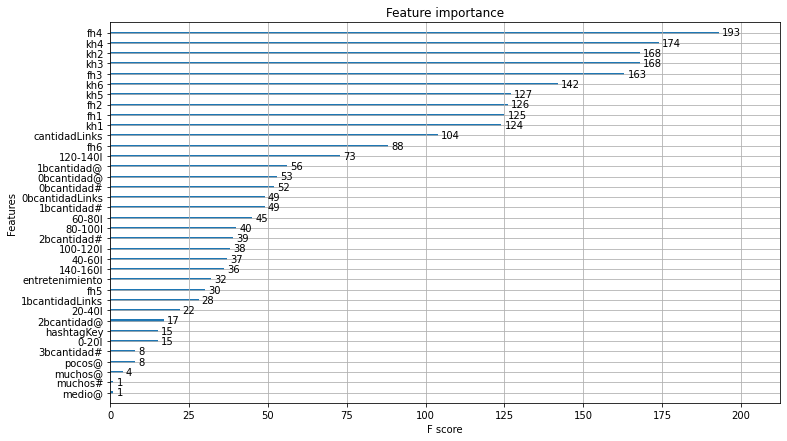

In [ ]:
from xgboost import plot_importance
plt.rcParams['figure.figsize'] = [12, 7]
plot_importance(model)
pyplot.savefig('xgboost.png')
pyplot.show()

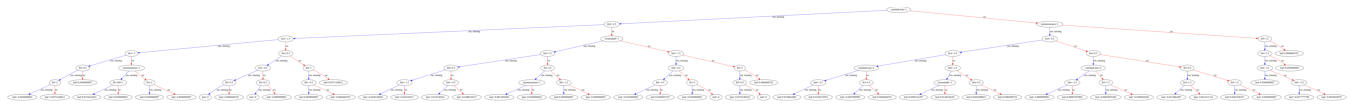

In [48]:
plt.rcParams['figure.figsize'] = [24,24]
xgb.plot_tree(xg_reg,num_trees=0)
xgb.to_graphviz(xg_reg,num_trees=0)
plt.show()

[0]	validation_0-error:0.338095	validation_0-logloss:0.681168	validation_1-error:0.346684	validation_1-logloss:0.682189
[1]	validation_0-error:0.338095	validation_0-logloss:0.671472	validation_1-error:0.346684	validation_1-logloss:0.673382
[2]	validation_0-error:0.33087	validation_0-logloss:0.663548	validation_1-error:0.335522	validation_1-logloss:0.666158
[3]	validation_0-error:0.329392	validation_0-logloss:0.656878	validation_1-error:0.331582	validation_1-logloss:0.659739
[4]	validation_0-error:0.327915	validation_0-logloss:0.650942	validation_1-error:0.334209	validation_1-logloss:0.654705
[5]	validation_0-error:0.32775	validation_0-logloss:0.646196	validation_1-error:0.329613	validation_1-logloss:0.649915
[6]	validation_0-error:0.327258	validation_0-logloss:0.641413	validation_1-error:0.330269	validation_1-logloss:0.645581
[7]	validation_0-error:0.326765	validation_0-logloss:0.637945	validation_1-error:0.326986	validation_1-logloss:0.643012
[8]	validation_0-error:0.328736	validation

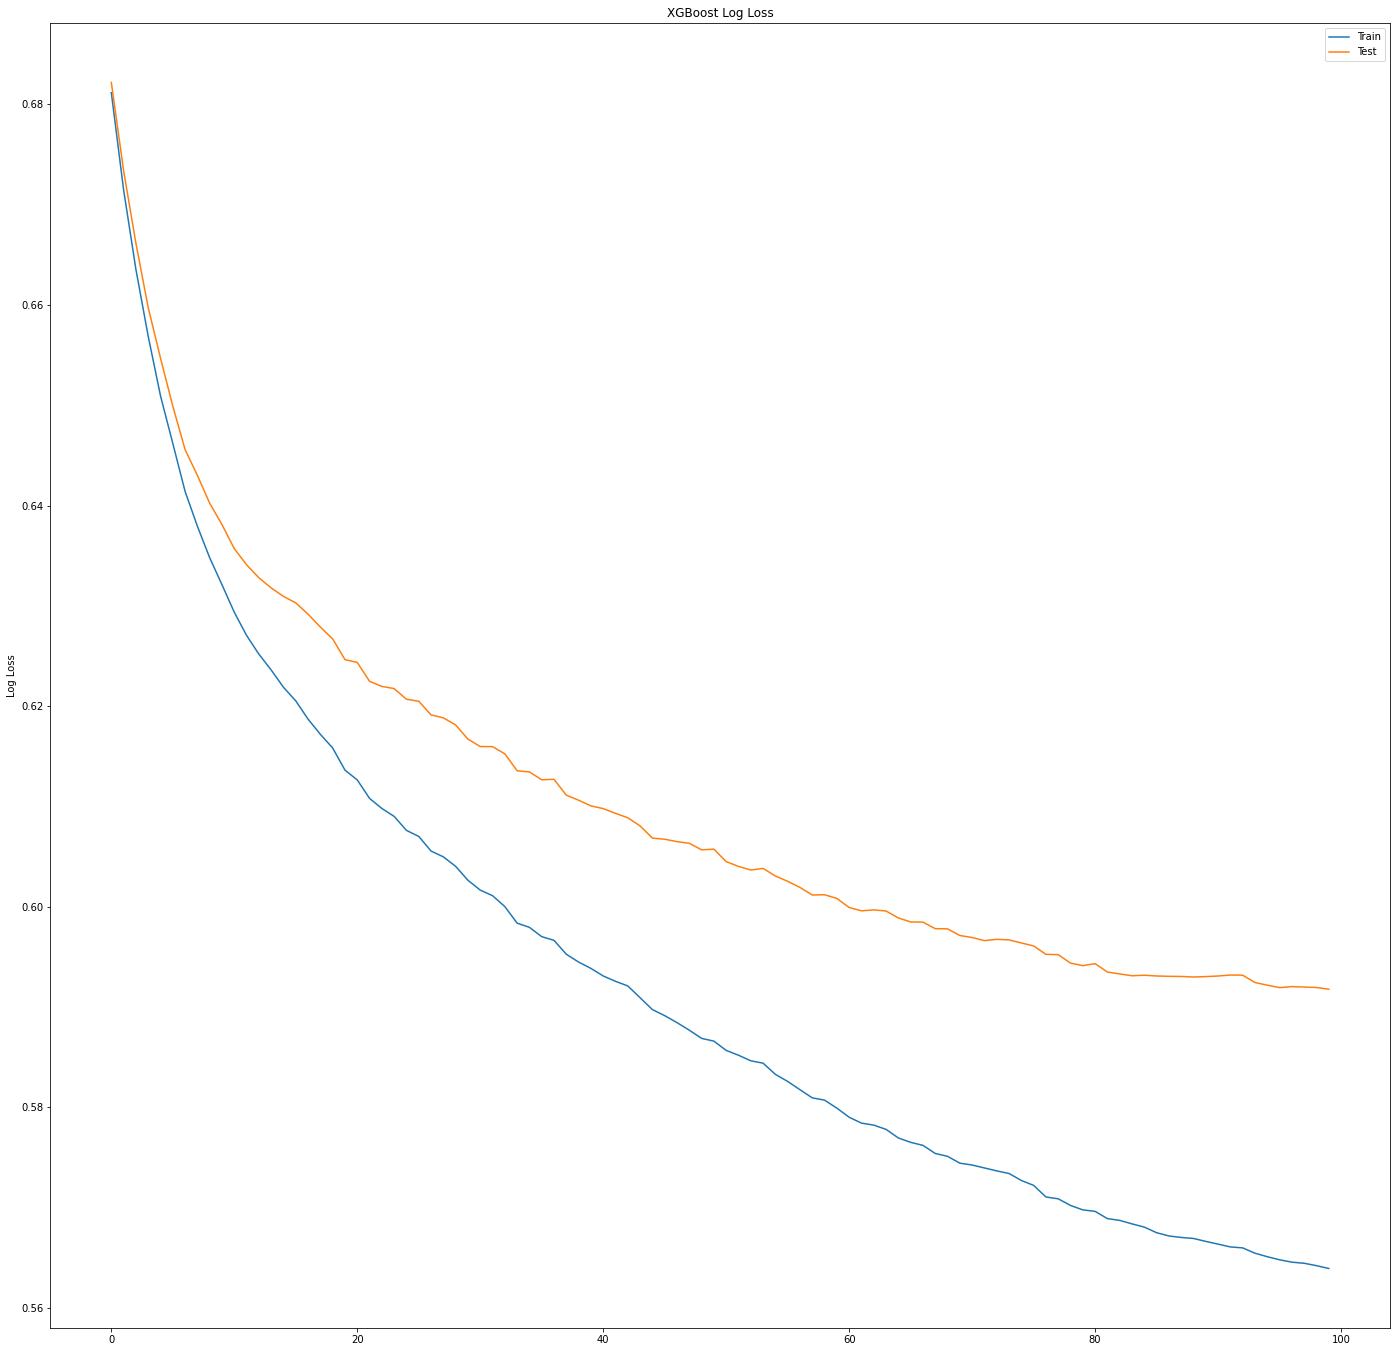

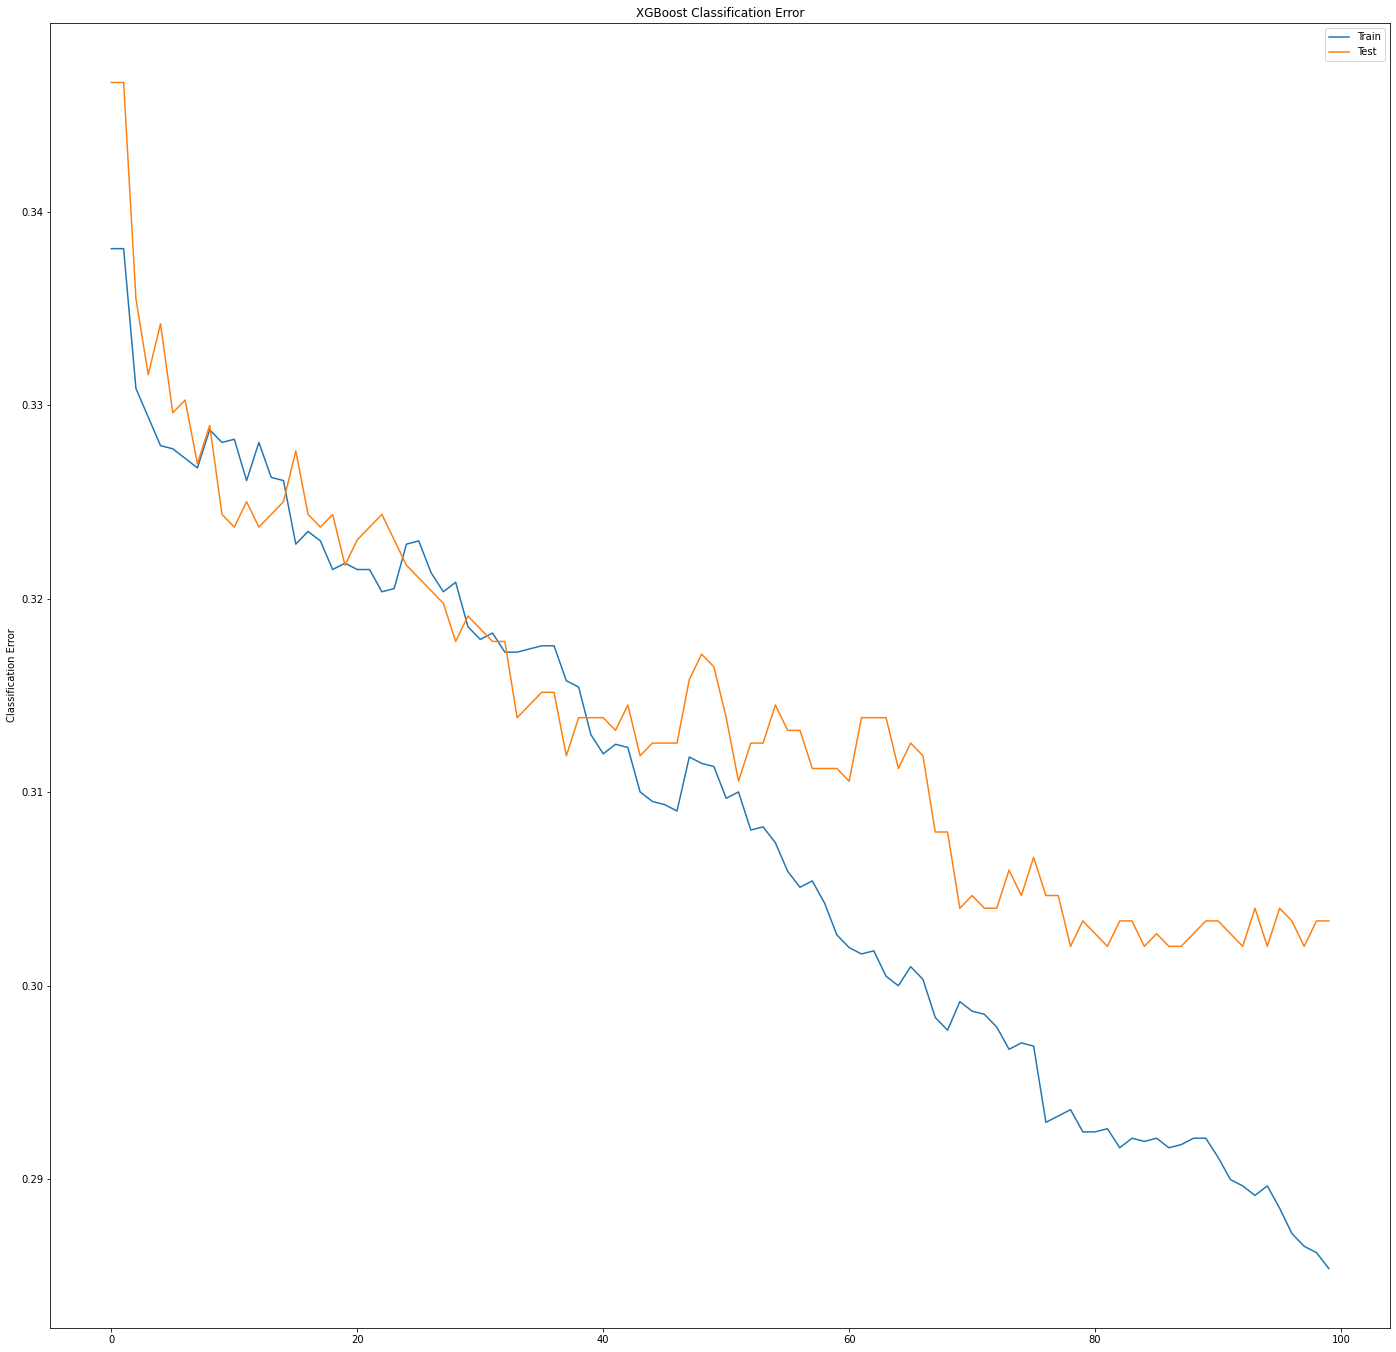

<Figure size 1728x1728 with 0 Axes>

In [50]:
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.savefig('logloss.png')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()
pyplot.savefig('classerr.png')

In [ ]:
label_encoded_y = LabelEncoder().fit_transform(target)
model = XGBClassifier()
colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bylevel=colsample_bylevel)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(colsample_bylevel, means, yerr=stds)
pyplot.title("XGBoost colsample_bylevel vs Log Loss")
pyplot.xlabel('colsample_bylevel')
pyplot.ylabel('Log Loss')
pyplot.savefig('colsample_bylevel.png')

In [ ]:
xg_reg.fit(entrenar,target)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=60,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
preds = xg_reg.predict(test)
preds = (preds>=0.5)*1
predictions = pd.DataFrame()
predictions['id']=datos['id']
predictions['target']=preds
predictions.head()
predictions.to_csv('resultados.csv',index=False)

In [ ]:
#!kaggle competitions submit -c nlp-getting-started -f resultados.csv -m "Nuevo intento"